# INCAWrapper validation case medium size model
In this notebook, we use the INCAWrapper to fit a simulated data. This notebook serves as an integration test the INCAWrapper that can be run when changes are made to the codebase to ensure that the INCAWrapper performs consistently. Furthermore, this case act as a validation case the show that the INCAWrapper actually works and that it is capable of estimating correct flux distribution from simulated data.

This notebook is not meant as a tutorial and therefore code description is a bit more sparse. For a proper tutorial see the other examples at https://incawrapper.readthedocs.io/en/latest/examples/index.html.

The model we use is from Alagesan, S., Minton, N.P. & Malys, N. 13C-assisted metabolic flux analysis to investigate heterotrophic and mixotrophic metabolism in Cupriavidus necator H16. Metabolomics 14, 9 (2018). https://doi.org/10.1007/s11306-017-1302-z, which is also used for one of the tutorials.

The simulation mimics a two parallel experiment where C. necator is grown with different labelled fructose and labelled glycerol. We simulated MS measurements of the amino acids and a few exchanges fluxes are measured. To increase the information about the systems we simulate measurements of CO2 exchange flux. To do this we added one additional reaction to the original model, i.e. CO2 -> CO2.ext. For more details about the simulation see the [simulation script](https://github.com/biosustain/incawrapper/blob/main/docs/examples/Literature%20data/Cupriavidus%20necator%2520%20Alagesan%202017/c_necator_simulation.py).

In [1]:
import pandas as pd
import numpy as np
import dotenv
import ast
import pandera as pa
import incawrapper
from incawrapper import utils
from incawrapper import visualization
import pathlib
import matplotlib.pyplot as plt
import pytest

In [2]:
# import environment variables
INCA_base_directory = dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory")

In [3]:
# set up path to data
working_dir = pathlib.Path(dotenv.find_dotenv()).parent
data_directory = working_dir / 'docs' / 'examples' / 'Literature data' / 'Cupriavidus necator  Alagesan 2017' / 'simulated_data'
results_file = data_directory / 'fit_simulated_fructose.mat'

In [4]:
# Reading the reactions, tracers, and simulated measurements
rxn = pd.read_csv(data_directory / 'reactions_processed.csv')
tracers = pd.read_csv(
    data_directory / 'tracer_info.csv', 
    converters={"atom_ids": ast.literal_eval, "atom_mdv": ast.literal_eval}
)
flux_measurements = pd.read_csv(data_directory / 'flux_measurements_no_noise.csv')
mdv_measurements = pd.read_csv(
    data_directory / 'mdv_no_noise.csv',
    converters={"labelled_atom_ids": ast.literal_eval}
)

is_ss_data = np.inf in mdv_measurements['time'].tolist()
if not is_ss_data:
    pool_sizes_measurements = pd.read_csv(data_directory / 'pool_sizes_measurement_no_noise.csv')

Looking at the traces dataframe, we can see the design of the two simulated parallel experiments

In [5]:
tracers

,experiment_id,met_id,tracer_id,atom_ids,atom_mdv,enrichment
0,simulation1,FRU.ext,D-[1-13C]fructose,[1],"[0.0, 1.0]",1
1,simulation2,FRU.ext,D-[2-13C]fructose,[2],"[0.0, 1.0]",1
2,simulation3,FRU.ext,D-[3-13C]fructose,[3],"[0.0, 1.0]",1
3,simulation4,FRU.ext,D-[4-13C]fructose,[4],"[0.0, 1.0]",1
4,simulation5,FRU.ext,D-[5-13C]fructose,[5],"[0.0, 1.0]",1
5,simulation6,FRU.ext,D-[6-13C]fructose,[6],"[0.0, 1.0]",1
6,simulation7,GLY.ext,[1-13C]-Glycerol,[1],"[0.0, 1.0]",1
7,simulation8,GLY.ext,[2-13C]-Glycerol,[2],"[0.0, 1.0]",1
8,simulation9,GLY.ext,[3-13C]-Glycerol,[3],"[0.0, 1.0]",1


We will now setup and run INCA.

In [6]:
script = incawrapper.create_inca_script_from_data(
    reactions_data=rxn,
    tracer_data=tracers,
    flux_measurements=flux_measurements,
    ms_measurements=mdv_measurements,
    pool_measurements = pool_sizes_measurements if not is_ss_data else None,
    experiment_ids=tracers.experiment_id.unique().tolist(),
)

script.add_to_block(
    "options",
    incawrapper.define_options(
        fit_starts=200,
        sim_ss=is_ss_data,
        sim_na=True,
        sim_more=True,
    )
)
script.add_to_block(
    "runner",
    incawrapper.define_runner(
        output_filename=results_file,
        run_estimate=True,
        run_continuation=True,
        run_simulation=True,
    )
)

In [7]:
incawrapper.run_inca(
    inca_script=script,
    INCA_base_directory=INCA_base_directory,
)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmpmxgq3x7s/inca_script.m.
Starting MATLAB engine...
 
ms_simulation1 = 1x24 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 CO2 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_simulation1 = 1x24 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 CO2 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_simulation1 = 1x24 msdata object
 
fields: atoms  id  [idvs]  more  on  st

Now we can read in the fit and validate that the INCAWrapper was able to find the true simulated fluxes. 

In [8]:
# read in the fitted fluxes
res = incawrapper.INCAResults(results_file)

# get the goodness of fit
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 5.2403884409445e-15
Expected chi-square range: [579.35427665 720.43349345]


The SSR is very small which indicate over-fitting, however this is expected because this is simulated data without any measurement error or bias'.

We can now load the true flux distribution and compare the to fitted. The true (simulated) flux distribution has some very small values, these are rounded as they cause some issues in the comparison.

In [9]:
true_fluxes = (pd.read_csv(data_directory / 'true_fluxes.csv')
    .round(6)
)

In [10]:
# combines the fitted and true fluxes
true_and_fitted_fluxes = pd.merge(
    res.fitdata.fitted_parameters.query("type.str.contains('flux')"),
    true_fluxes.rename(columns={"rxn_id": "id", "flux": "val"}),
    on="id",
    suffixes=("_fitted", "_true"),
).fillna({
    "lb" : -np.inf,
    "ub" : np.inf
})

INCA is not able to make an exact match to the true fluxes because there are to few measurements. Therefore, we will check fraction of the true fluxes are within the estimated upper and lower bounds.

In [11]:
def is_in_interval(x, lb, ub):
    return (x >= lb) & (x <= ub)

# few tests to validate function
assert is_in_interval(4.5,-np.inf,10) == True
assert is_in_interval(4.5,0,10) == True
assert is_in_interval(10,0,4.5) == False

true_vals_in_interval = true_and_fitted_fluxes.apply(
    lambda x: is_in_interval(x['val_true'], x['lb'], x['ub']), axis=1
)

fraction_correct_fluxes = true_vals_in_interval.sum() / true_vals_in_interval.size
fraction_correct_fluxes

0.9736842105263158

In [12]:
true_and_fitted_fluxes[~true_vals_in_interval]

,type,id,eqn,val_fitted,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base,val_true
25,Net flux,R24 net,MAL <-> OAA,108.979781,2349.807894,60.670798,111.888482,[],0,0.05,"[3.994719540983011, 3.2269911683924146, 2.4593...",0,"[-0.8649564540342508, 0.8734714211977712, 0.87...","[-1098.7166310664484, 2197.45564349542, 2197.4...","[60.57914836312831, 61.06237860136113, 61.6065...",{'id': []},59.500428
31,Net flux,R30,MAL -> PYR + CO2,0.000003,2349.807578,0.000000,48.027221,[],1,0.05,"[5.2403942694410005e-15, 5.2403884409445e-15, ...",0,"[0.8649604172700449, -0.8734654197666162, -0.8...","[1098.721517822077, -2197.4402501170603, -2197...","[0.0, 2.676942781281405e-06, 2.676942781281405...",{'id': []},49.479355


We can also vizualize the fitted and true fluxes. Note that some fluxes have very large bounds, we these are truncated for visualization purposes.

(-250.0, 400.0)

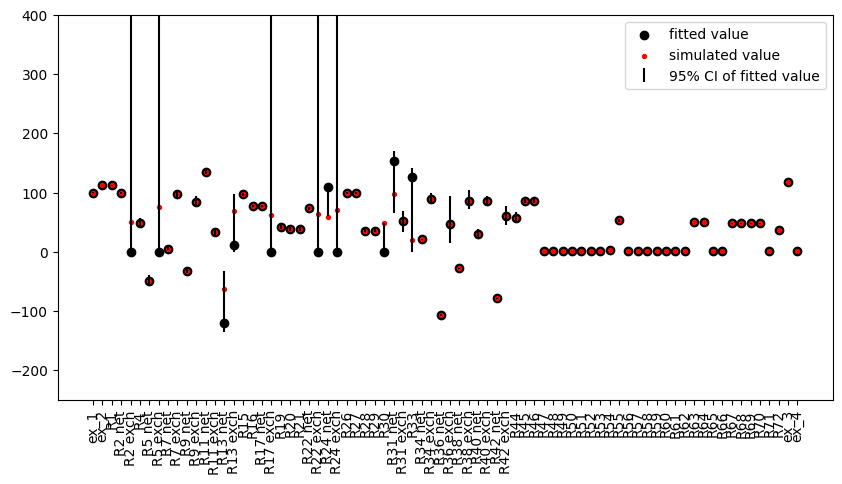

In [13]:
yaxis_range = [-250, 400]
plot_df = true_and_fitted_fluxes.copy()
# replace inf with large number
plot_df['lb'].replace(np.inf, yaxis_range[0], inplace=True)
plot_df['ub'].replace(np.inf, yaxis_range[1], inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
errbars = plot_df[['lb', 'ub']].subtract(plot_df['val_fitted'], axis=0).abs().T
ax.scatter(x=plot_df['id'], y=plot_df['val_fitted'], color='black', label='fitted value')
ax.errorbar(x=plot_df['id'], y=plot_df['val_fitted'], yerr=errbars, color='black', fmt='none', label='95% CI of fitted value')
ax.scatter(x=plot_df['id'], y=plot_df['val_true'], color='red', label='simulated value', s=8)
# rotate x-axis labels
ax.tick_params(axis='x', labelrotation=90)
ax.legend()
ax.set_ylim(yaxis_range)

We see that most of the true flux value lies close to the estimated flux value. However, some of the flux estimates have large uncertainties. Therefor, we investigate how many fluxes are "well determined".

In [14]:
def well_determined_fluxes(val, lb, ub, cutoff):
    '''Finds well defined fluxes, these are fluxes where the relative uncertainty span is less than the cutoff.'''
    if val == 0:
        relative_uncertainty_span = (ub - lb) 
    else:
        relative_uncertainty_span = (ub - lb) / np.abs(val)
    return relative_uncertainty_span < cutoff

assert well_determined_fluxes(1, 0.9, 1.1, 0.21) == True
assert well_determined_fluxes(1, 0.9, 1.1, 0.1) == False
assert well_determined_fluxes(0, -0.49, 0.49, 1) == True

In [15]:
true_and_fitted_fluxes['well_determined'] = true_and_fitted_fluxes.apply(
    lambda x: well_determined_fluxes(x['val_true'], x['lb'], x['ub'], 1), axis=1
)
true_and_fitted_fluxes['well_determined'].sum() / true_and_fitted_fluxes['well_determined'].size

0.868421052631579

We see that only 37% of the fluxes are well determined using a cutoff=1. This shows that the simulated experiments do not contain sufficient information about the flux distribution to gain an accurate estimate. This could likely be improve by introducing more simulated parallel experiments, using other labelled substrates. However, some fluxes, e.g. the exchange flux of reversible reactions, can be difficult to estimate at all.

We will calculate the fraction of well determined net fluxes

In [16]:
net_fluxes = true_and_fitted_fluxes['type'] == 'Net flux'
true_and_fitted_fluxes.loc[net_fluxes, 'well_determined'].sum() / net_fluxes.sum()

0.9508196721311475

In [17]:
true_and_fitted_fluxes.query("well_determined == False")

,type,id,eqn,val_fitted,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base,val_true,well_determined
4,Exch flux,R2 exch,F6P <-> G6P,0.000203,5945.546659,0.000000,4.565132e+05,[],1,0.05,"[5.240394666182686e-15, 5.2403884409445e-15, 5...",0,"[1.0242279254069224e-18, -7.638497776012601e-1...","[3.291906570154729e-15, -4.862267042200434e-15...","[0.0, 0.00020273211844921402, 0.00020273211844...",{'id': []},50.063257,False
7,Exch flux,R5 exch,F16P <-> DHAP + G3P,0.131817,24.857961,0.000000,inf,[],1,0.05,"[5.240377690294963e-15, 5.2403884409445e-15, 5...",0,"[0.01822227403779985, -0.0189877907265453, -0....","[0.24486526064289388, -0.5053345603876924, -0....","[0.0, 0.13181694807872396, 0.13181694807872396...",{'id': []},75.711541,False
14,Net flux,R13 net,PEP <-> PYR,-120.043527,4425.322567,-135.120510,-3.297216e+01,[],0,0.05,"[4.130683146091691, 3.513792281295319, 2.74993...",0,"[0.8649623940512801, -0.8734711448342483, -0.8...","[2069.1942118317684, -4138.400844588117, -4138...","[-135.381046285033, -134.7490981678393, -133.5...",{'id': []},-63.384003,False
15,Exch flux,R13 exch,PEP <-> PYR,11.648474,4425.322090,0.000000,9.818910e+01,[],1,0.05,"[2.5412331261300642, 2.4563086756270556, 2.417...",0,"[0.8649653466806049, -0.8734691138704825, -0.8...","[2069.201052205068, -4138.3907761022165, -4138...","[0.0, 0.19897293382503722, 0.2912829047507193,...",{'id': []},68.307999,False
19,Exch flux,R17 exch,CIT <-> ISCIT,0.004421,7597.461619,0.000000,3.528013e+05,[],1,0.05,"[5.2403876701293136e-15, 5.2403884409445e-15, ...",0,"[8.558915753820034e-09, -4.357919790841459e-09...","[3.5151702400791606e-05, -3.5447597556903584e-...","[0.0, 0.004420992590671501, 0.0044209925906715...",{'id': []},61.408078,False
24,Exch flux,R22 exch,SUC <-> MAL,0.003581,8234.444090,0.000000,3.357802e+05,[],1,0.05,"[5.240392208091853e-15, 5.2403884409445e-15, 5...",0,"[-2.544757322281611e-07, -1.1945626573260763e-...","[-0.001132764823753316, -0.010531307129367845,...","[0.0, 0.0035806718026947237, 0.003580671802694...",{'id': []},63.271775,False
26,Exch flux,R24 exch,MAL <-> OAA,0.000003,5904.544787,0.000000,4.982768e+05,[],1,0.05,"[5.240395388857807e-15, 5.2403884409445e-15, 5...",0,"[-1.4796150759704207e-08, 1.3894991023244118e-...","[-4.722742481222363e-05, 8.783826535704151e-05...","[0.0, 2.6788361964233967e-06, 2.67883619642339...",{'id': []},70.249786,False
32,Net flux,R31 net,PEP + CO2 <-> OAA,153.817239,4425.323238,65.279956,1.699708e+02,[],1,0.05,"[3.8453117265919645, 3.0767457183336244, 2.308...",0,"[-0.8649646679646182, 0.8734729905621471, 0.87...","[-2069.1999654734886, 4138.410217234223, 4138....","[65.27684516498883, 65.94233087168575, 66.6982...",{'id': []},97.157715,False
34,Net flux,R33,OAA -> PYR + CO2,125.868018,6775.127815,0.000000,1.414760e+02,[],1,0.05,"[9.64311081628056e-07, 5.2403884409445e-15, 5....",0,"[-0.8649619894530006, 0.8734690372062959, 0.87...","[-3167.915669295733, 6335.838030593168, 6335.8...","[0.0, 125.86801789391164, 125.86801789391164, ...",{'id': []},19.729141,False
38,Exch flux,R36 exch,RU5P <-> X5P,46.672275,19.088664,15.354439,9.398360e+01,[],1,0.05,"[4.5497012287545475, 3.7698245527534313, 3.629...",0,"[-0.0015311261049366725, -0.000979221704556305...","[-0.015799581712239795, -0.020012236284784483,...","[13.047684997665954, 15.599024485059383, 16.09...",{'id': []},46.672275,False


In [18]:
def relative_error(true_val, fitted_val, replace_zero=1e-7):
    if true_val == 0.0:
        true_val = replace_zero
    return np.abs(true_val - fitted_val) / np.abs(true_val)

assert relative_error(1, 1) == 0
assert relative_error(1, 2) == 1

In [19]:
relative_error_cutoff = 0.01
true_and_fitted_fluxes['relative_error'] = true_and_fitted_fluxes.apply(
    lambda x: relative_error(x['val_true'], x['val_fitted']), axis=1
)
fraction_fluxes_below_rel_error_cutoff = true_and_fitted_fluxes.loc[true_and_fitted_fluxes.relative_error < relative_error_cutoff, 'relative_error'].size / true_and_fitted_fluxes['relative_error'].size
print(
    str(fraction_fluxes_below_rel_error_cutoff * 100) + "% of fluxes have a relative error below " + str(relative_error_cutoff)
)

85.52631578947368% of fluxes have a relative error below 0.01


This is still not super impressive, however, visual inspection of the plot shows that the flux estimate is in good agreement with the simulated flux distribution. We strongly believe that this performance is due lack of information in the simulated data, rather that errors in the INCAWrapper.

Finally, we have a few tests which validates that the analysis was consistent with earlier runs for testing purposes.

In [20]:
## Setup validation tests that test that the results are similar to the previous run
# Test that the fraction of correct fluxes similar to ealier run
assert fraction_correct_fluxes == 1.0

# Test that the chi2 is similar to ealier run, this test may be fragile because the flux 
# estimation is stochastic. Therefore, we only test that the chi2 very small (i.e. < 5).
assert res.fitdata.chi2 < 5

# Test that the fraction of well determined fluxes is similar to ealier run
assert true_and_fitted_fluxes['well_determined'].sum() / true_and_fitted_fluxes['well_determined'].size == pytest.approx(0.373, 0.005)
assert true_and_fitted_fluxes.loc[net_fluxes, 'well_determined'].sum() / net_fluxes.sum() == pytest.approx(0.45, 0.005)

AssertionError: 

In [ ]:
res_simulations = incawrapper.INCAResults(pathlib.Path(data_directory. parent / "c_necator_simulation.mat"))
simulated_data = res_simulations.simulation.simulated_data
simulated_data.head()

,expt,id,time,type,mdv,mass_isotope
0,inst1,Alanine232,0.0,MS,0.755116,0
0,inst1,Alanine232,0.0,MS,0.165499,1
0,inst1,Alanine232,0.0,MS,0.067874,2
0,inst1,Alanine232,0.0,MS,0.009721,3
0,inst1,Alanine232,0.0,MS,0.001635,4


/Users/s143838/.virtualenvs/incawrapper-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


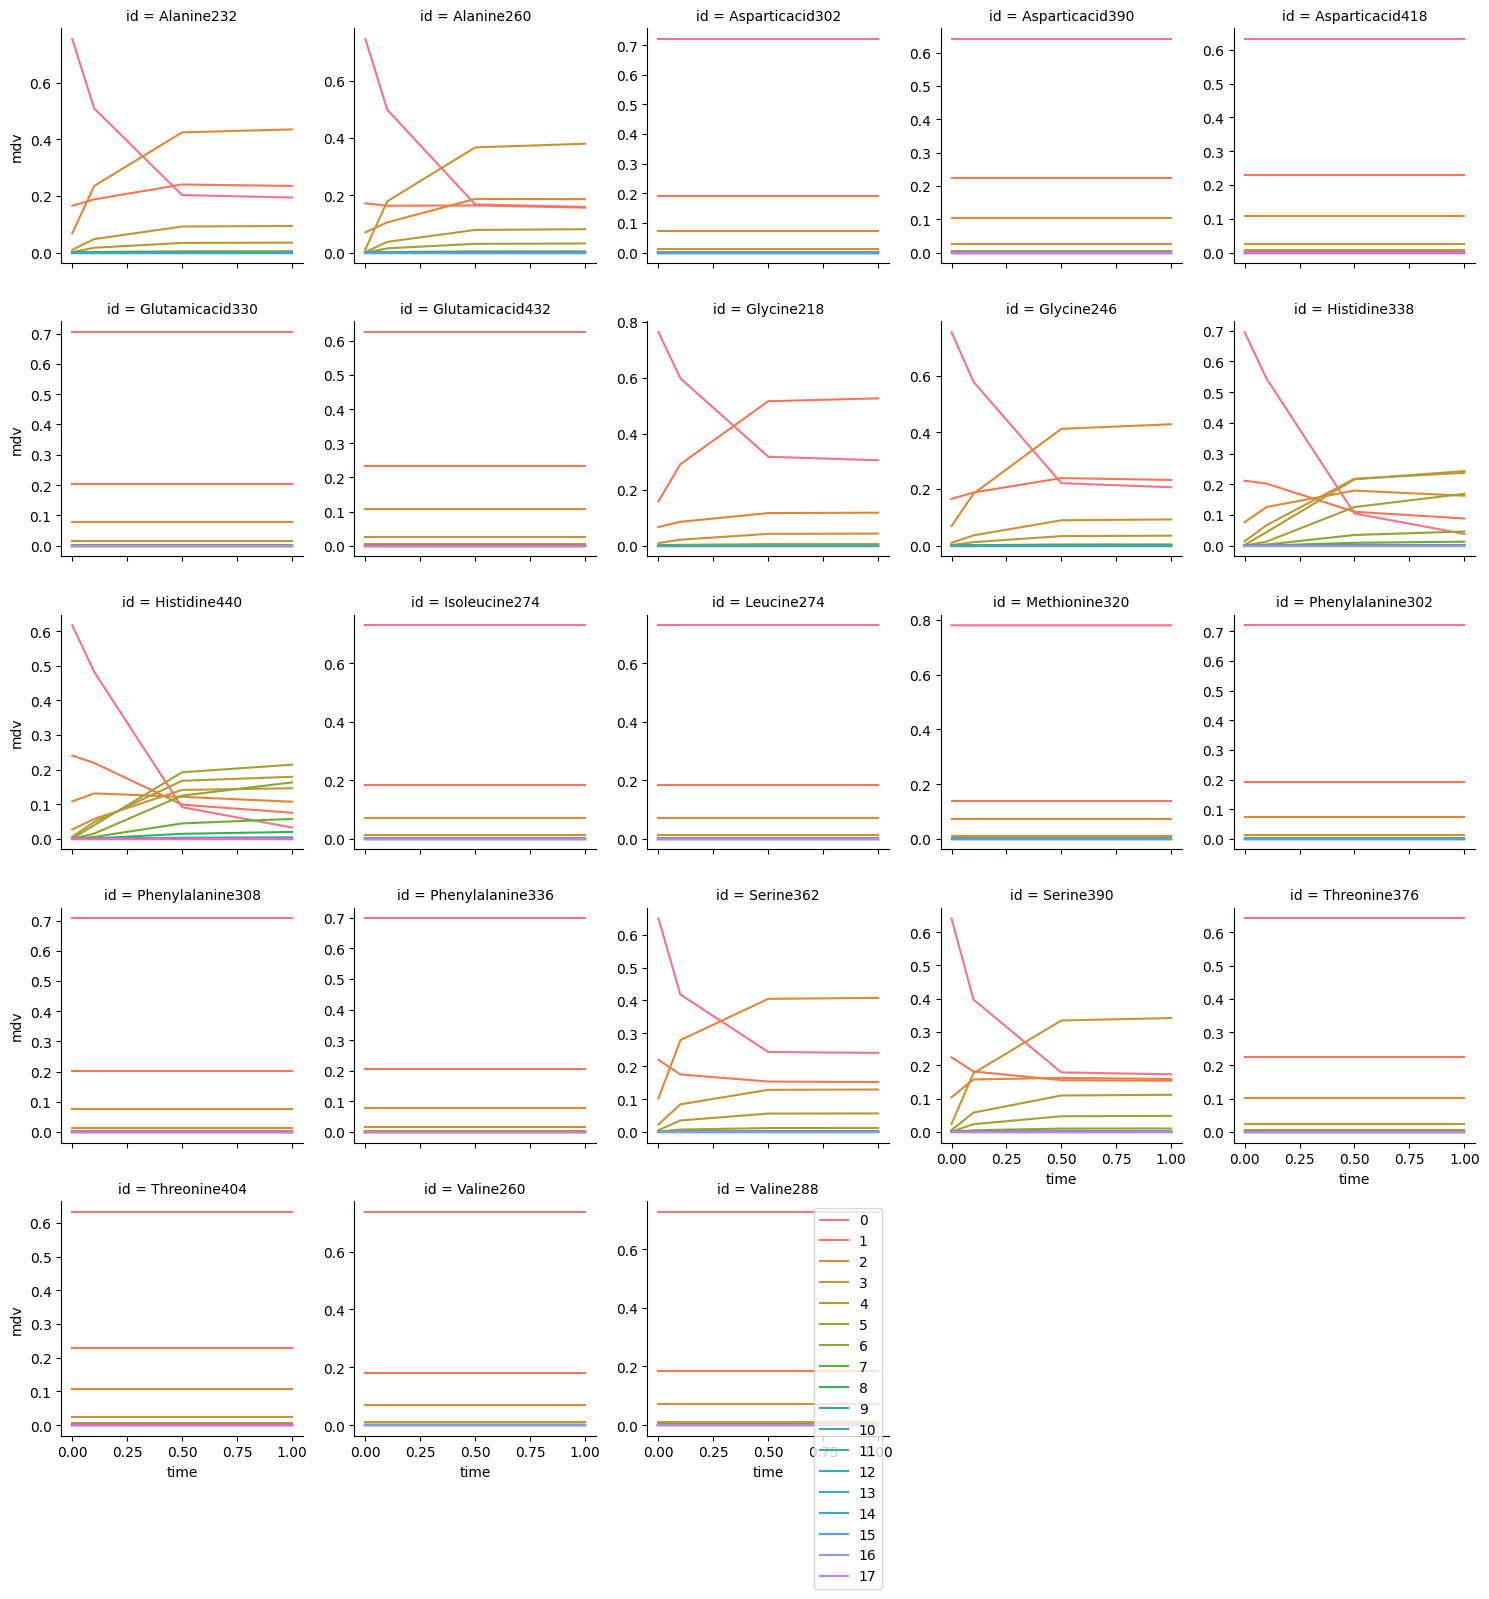

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
g = sns.FacetGrid(simulated_data.query("expt == 'inst1'"), col="id", col_wrap=5, hue="mass_isotope", sharey=False)
g.map_dataframe(sns.lineplot, x="time", y="mdv")
plt.legend()